# Проект промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» необходимо уменьшить потребление электроэнергии на этапе обработки стали. 

**Цель:** необходимо построить модель, которая предскажет температуру стали.

Сталеплавильный процесс — окислительный процесс, так как сталь получается в результате окисления и удаления большей части примесей чугуна — углерода, кремния, марганца, серы и фосфора (за исключением электросталеплавильного процесса, где в основном используется исключительно металлом в шихте). Отличительной особенностью сталеплавильных процессов является наличие окислительной атмосферы. Окисление примесей чугуна и других шихтовых материалов осуществляется кислородом, содержащимся в газах, оксидах железа и марганца. После окисления примесей, из металлического сплава удаляют растворённый в нём кислород, вводят легирующие элементы и получают сталь заданного химического состава.

## План работы

1.   Открываем и исследуем данные
- Загрузка данных
- Статистические данные 
- Посмотреть распределения данных
- Изучить пропуски
- Удалить или заменить дубликаты, пропуски и выбросы (обратить внимание на партии, где нет последнего замера температуры, тк это целевой признак)
- Выбрать подходящие данные (первый и последний)
- Составить таблицу с признаками
2. Подготовка данных
- Исследуем корреляцию между признаками
- Масштабируем признаки
- Разделяем на выборки (тестовую и обучающую)
3. Обучение моделей
- Предположительно LinearRegression,RandomForest, CatBoost или LGBMRegressor 
- Выбор лучшей модели по показателю MAE
4. Тестирование модели
- Модель с наименьшим MAE проверяем на тестовой выборке
5. Вывод. Отчет
- Вывод результатов, общий вывод, написание отчета

## Исследовательский анализ

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.dummy import DummyRegressor

from sklearn import datasets
from catboost import cv
from sklearn.feature_selection import SelectFromModel
import matplotlib
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

In [2]:
RANDOM_STATE = 310723

In [3]:
df_arc=pd.read_csv('/datasets/data_arc_new.csv') #данные об электродах
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [4]:
df_bulk=pd.read_csv('/datasets/data_bulk_new.csv') #данные о подаче сыпучих материалов (объём)
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [5]:
df_bulk_time=pd.read_csv('/datasets/data_bulk_time_new.csv') #данные о подаче сыпучих материалов (время)
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [6]:
df_gas=pd.read_csv('/datasets/data_gas_new.csv') #данные о продувке сплава газом
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [7]:
df_temp=pd.read_csv('/datasets/data_temp_new.csv') #результаты измерения температуры
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [8]:
df_wire=pd.read_csv('/datasets/data_wire_new.csv') #данные о проволочных материалах (объём)
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_wire_time=pd.read_csv('/datasets/data_wire_time_new.csv') #данные о проволочных материалах (время)
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
def statistics (df):
    info = df.info() 
    print(f"Общая информация\n {info}\n")
    describe = df.describe()
    print(f'Cтатистическиe данные\n {describe}\n')
    duplicated = df.duplicated().sum()
    print(f'Количествo дубликатов\n {duplicated}\n')
    isna = df.isna().sum()
    print(f'Количествo пропусков\n {isna}')
    df.hist(figsize=(10,10));

### Электроды

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
Общая информация
 None

Cтатистическиe данные
                 key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75% 

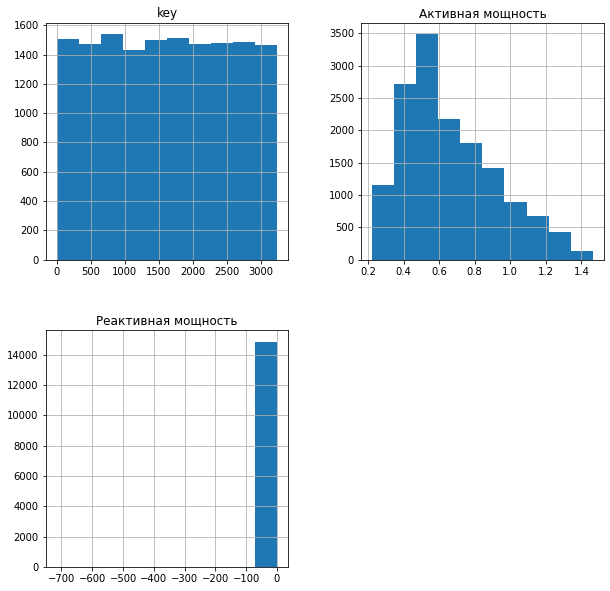

In [11]:
print(statistics(df_arc))

In [12]:
#df_arc = df_arc.drop(df_arc[df_arc['Активная мощность'] <= 0].index).reset_index(drop=True)
df_arc = df_arc.drop(df_arc[df_arc['Реактивная мощность'] <= 0].index).reset_index(drop=True)

In [13]:
df_arc['Среднее значение мощности'] = df_arc[['Активная мощность', 'Реактивная мощность']].mean(axis=1)
df_arc = df_arc.drop(['Активная мощность', 'Реактивная мощность'], axis=1)
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Среднее значение мощности
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.258192
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.621548
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.505386
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.449237
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.755412
...,...,...,...,...
14870,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.369657
14871,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.552369
14872,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,0.904514
14873,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.445905


Распределение активной мощности похоже на нормальное. Были удалены данные, где Реактиваня мощность - отрицательная, так как мощность должна быть положительной. Пропусков и дубликатов нет, данные чистые.Значения в key - не уникальны.

###  Сыпучиe материалы (Объем)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
Общая информация
 None

Cтатистическиe данные
                key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.0

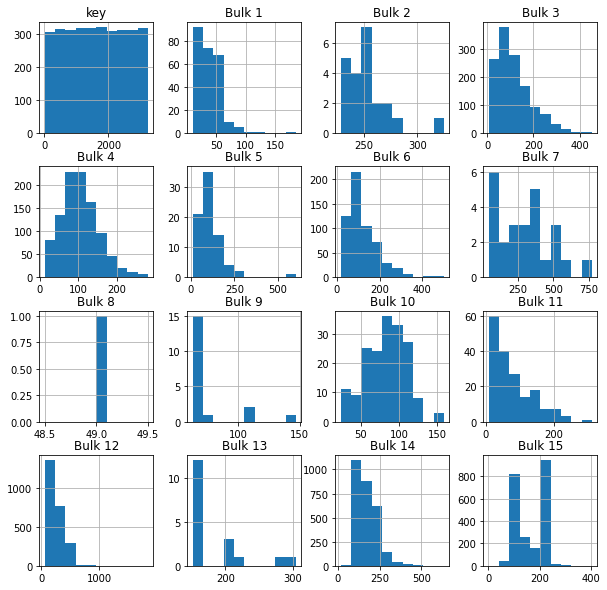

In [14]:
print(statistics(df_bulk))

Заменим пропуски на нули для дальнейшего упрощения рассчетов

In [15]:
df_bulk = df_bulk.fillna(0)

###  Сыпучиe материалы (Время)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
Общая информация
 None

Cтатистическиe данные
                key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.0

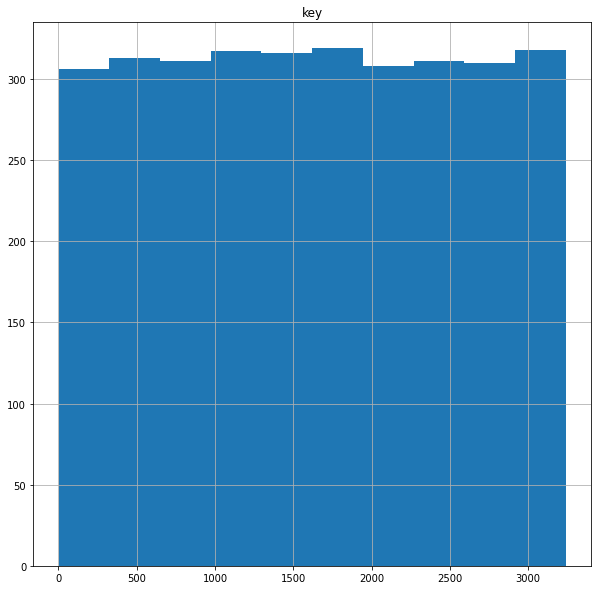

In [16]:
print(statistics(df_bulk_time))

### Продувка сплава газом

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
Общая информация
 None

Cтатистическиe данные
                key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

Количествo дубликатов
 0

Количествo пропусков
 key      0
Газ 1    0
dtype: int64
None


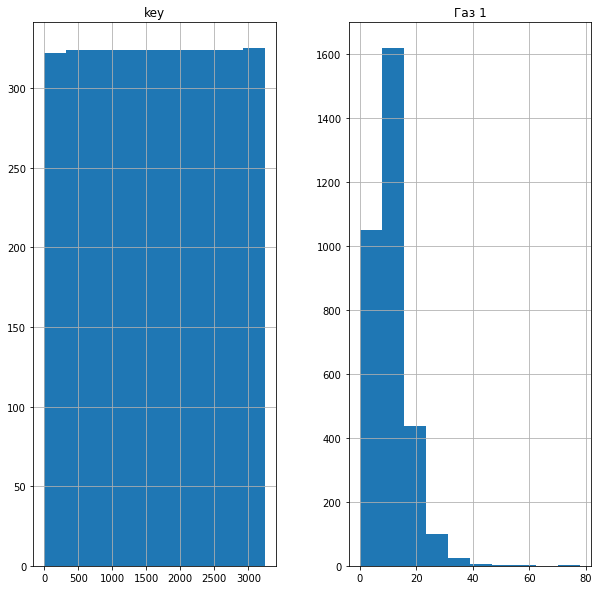

In [17]:
print(statistics(df_gas))

### Результаты измерения температуры

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
Общая информация
 None

Cтатистическиe данные
                 key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000

Количествo дубликатов
 0

Количествo пропусков
 key                0
Время замера       0
Температура     3427
dtype: int64
None


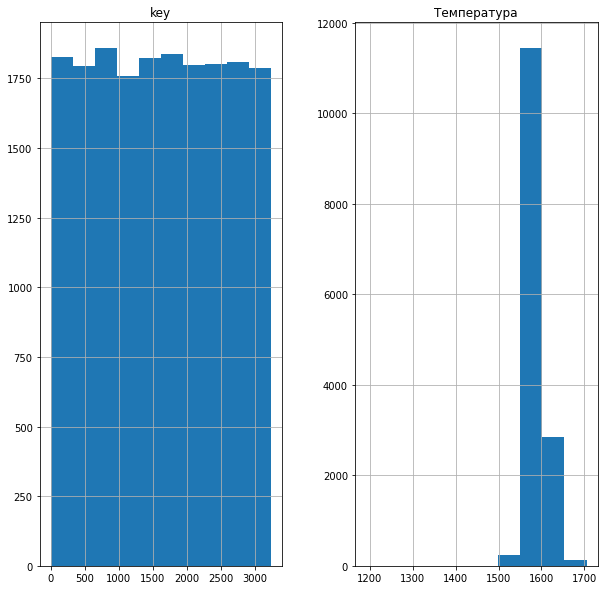

In [18]:
print(statistics(df_temp))

Удалим пропуски, так как они составляют меньше 10% от всех данных 

In [19]:
df_temp = df_temp.dropna(axis=0)
df_temp.reset_index(drop=True, inplace=True)

Удалим строки, оставив только начальное и конечное значение, если у температуры значение только одно, то такие данные мы тоже удаляем, ведь у нас нет конечной температуры.

In [20]:
df_temp = df_temp.groupby(by = 'key', as_index = False).agg(['first', 'last'])

In [21]:
df_temp.head()

Время замера                      Температура        
                   first                 last       first    last
key                                                              
1    2019-05-03 11:02:04  2019-05-03 11:30:38      1571.0  1613.0
2    2019-05-03 11:34:04  2019-05-03 11:55:09      1581.0  1602.0
3    2019-05-03 12:06:44  2019-05-03 12:35:57      1596.0  1599.0
4    2019-05-03 12:39:27  2019-05-03 12:59:47      1601.0  1625.0
5    2019-05-03 13:11:03  2019-05-03 13:36:39      1576.0  1602.0

In [22]:
df_temp.columns = ['Время 1', 'Время 2','Температура 1','Температура 2']
df_temp

,Время 1,Время 2,Температура 1,Температура 2
key,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0
...,...,...,...,...
3237,2019-09-06 11:31:15,2019-09-06 11:31:15,1569.0,1569.0
3238,2019-09-06 12:16:15,2019-09-06 12:16:15,1584.0,1584.0
3239,2019-09-06 14:16:50,2019-09-06 14:16:50,1598.0,1598.0


In [23]:
df_temp = df_temp.drop(df_temp[df_temp['Время 1'] == df_temp['Время 2']].index)

In [24]:
df_temp

,Время 1,Время 2,Температура 1,Температура 2
key,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0
...,...,...,...,...
2495,2019-08-10 11:27:47,2019-08-10 11:50:47,1570.0,1591.0
2496,2019-08-10 11:56:48,2019-08-10 12:25:13,1554.0,1591.0
2497,2019-08-10 12:37:26,2019-08-10 12:53:28,1571.0,1589.0


Партии у которых нет конечной температуры нам не актуальны

### Проволочные материалы (Объем)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
Общая информация
 None

Cтатистическиe данные
                key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.91880

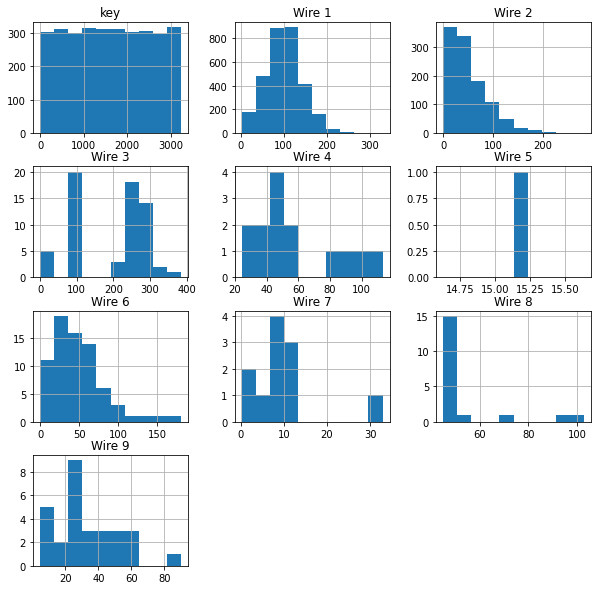

In [25]:
print(statistics(df_wire))

In [26]:
#заменим пропуски нулями 
df_wire = df_wire.fillna(0)

### Проволочные материалы (Время)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
Общая информация
 None

Cтатистическиe данные
                key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

Количествo дубликатов
 0

Количествo пропусков
 key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9 

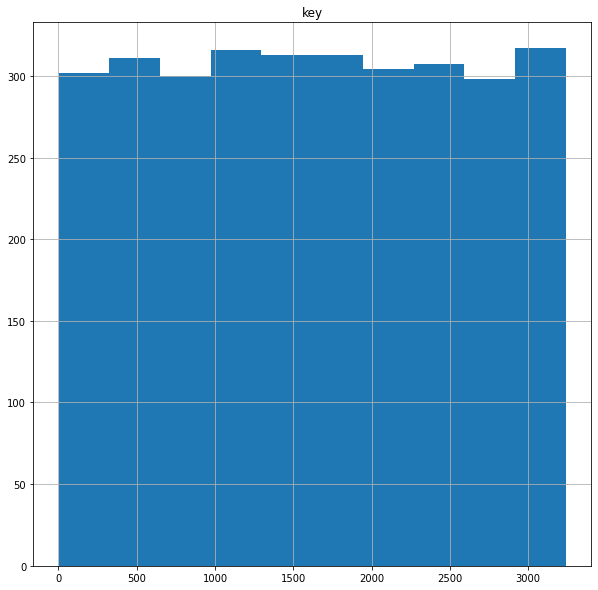

In [27]:
print(statistics(df_wire_time))

In [28]:
#заменим пропуски нулями 
df_wire_time = df_wire_time.fillna(0)

### Итоговый вывод по плану 

На данном этапе мы изучили процесс сталеплавления, уточнили детали и составили план нашей работы. 
На этапе исследовтельского анализа мы обработали 7 датасетов. Нашли их статистические данные, построили гистограммы, обработали пропуски

- df_arc - электроды. В столбце реактивной мнощности были удалены отрицательные значения. Значение мощностей записали как их среднее значение (убираем сложности рассчета для вычисления работы, полной мощности)
- df_bulk - сыпучие материалы. Пропуски мы заменили нулями, так как пропущенные значения означают, что данные примеси не добавлялись. 
- df_bulk_time. Пропуски в данном датасете совпадают по количеству с пропусками в df_bulk.
- df_gas - продувка газом. Пропусков нет, дубликатов нет - данные чистые
- df_temp - температура. Пропуски были удалены, так как их небольшое количество. Так же данные без конечной температуры для нас неактуальны, их мы тоже удалили. В итоговом датафрейме оставили только начальную и конечную температуры.(промежуточную удалили)
- df_wire - проволочные материалы.  Пропуски мы заменили нулями, так как пропущенные значения означают, что данные примеси не добавлялись. 
- df_wire_time.  Пропуски в данном датасете совпадают по количеству с пропусками в df_wire.


Удалили все ненужные значения, 

Во всех таблицах количество значений key разное, это надо будет учесть при объединении.

Целевой признак - конечная температура

## Создаем таблицу со всеми признаками

У нас есть столбцы с временем, которые в обучение не будут играть роли, но мы можем сделать из таких столбцов новый признак.

Например df_temp и df_arc. 

In [29]:
# Преобразование столбца в тип datetime
df_temp['Время 1'] = pd.to_datetime(df_temp['Время 1'])
df_temp['Время 2'] = pd.to_datetime(df_temp['Время 2'])
# Создание столбца 
df_temp['Время нагрева(сек)'] = df_temp['Время 2'] - df_temp['Время 1']
df_temp['Время нагрева(сек)'] = df_temp['Время нагрева(сек)'].dt.seconds
# Вывод датафрейма
print(df_temp)

                 Время 1             Время 2  Температура 1  Температура 2  \
key                                                                          
1    2019-05-03 11:02:04 2019-05-03 11:30:38         1571.0         1613.0   
2    2019-05-03 11:34:04 2019-05-03 11:55:09         1581.0         1602.0   
3    2019-05-03 12:06:44 2019-05-03 12:35:57         1596.0         1599.0   
4    2019-05-03 12:39:27 2019-05-03 12:59:47         1601.0         1625.0   
5    2019-05-03 13:11:03 2019-05-03 13:36:39         1576.0         1602.0   
...                  ...                 ...            ...            ...   
2495 2019-08-10 11:27:47 2019-08-10 11:50:47         1570.0         1591.0   
2496 2019-08-10 11:56:48 2019-08-10 12:25:13         1554.0         1591.0   
2497 2019-08-10 12:37:26 2019-08-10 12:53:28         1571.0         1589.0   
2498 2019-08-10 12:58:11 2019-08-10 13:23:31         1591.0         1594.0   
2499 2019-08-10 13:33:21 2019-08-10 13:58:58         1569.0     

In [30]:
# Преобразование столбца в тип datetime
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])
# Создание столбца
df_arc['Время нагрева дугой(сек)'] = df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']
df_arc['Время нагрева дугой(сек)'] = df_arc['Время нагрева дугой(сек)'].dt.seconds
# Вывод датафрейма сгруппированного по key
df_arc = df_arc.groupby('key').agg({'Среднее значение мощности': 'mean', 'Время нагрева дугой(сек)': 'sum'})
print(df_arc)

      Среднее значение мощности  Время нагрева дугой(сек)
key                                                      
1                      0.517955                      1098
2                      0.449096                       811
3                      0.700110                       655
4                      0.595435                       741
5                      0.492618                       869
...                         ...                       ...
3237                   0.456729                       909
3238                   0.402154                       546
3239                   0.524347                      1216
3240                   0.569123                       839
3241                   0.518529                       659

[3214 rows x 2 columns]


In [31]:
df = (
    df_temp.merge(df_arc, how='inner', on = 'key')
    .merge(df_gas, how='inner', on = 'key')
    .merge(df_wire, how='inner', on = 'key')
    .merge(df_bulk, how='inner', on = 'key'))
df

,key,Время 1,Время 2,Температура 1,Температура 2,Время нагрева(сек),Среднее значение мощности,Время нагрева дугой(сек),Газ 1,Wire 1,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1714,0.517955,1098,29.749986,60.059998,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,1265,0.449096,811,12.555561,96.052315,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,1753,0.700110,655,28.554793,91.160157,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,1220,0.595435,741,18.841219,89.063515,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,1536,0.492618,869,5.413692,89.238236,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,2019-08-10 11:27:47,2019-08-10 11:50:47,1570.0,1591.0,1380,0.672384,723,7.125735,89.150879,...,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2325,2496,2019-08-10 11:56:48,2019-08-10 12:25:13,1554.0,1591.0,1705,0.587246,940,9.412616,114.179527,...,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2326,2497,2019-08-10 12:37:26,2019-08-10 12:53:28,1571.0,1589.0,962,1.009555,569,6.271699,94.086723,...,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0
2327,2498,2019-08-10 12:58:11,2019-08-10 13:23:31,1591.0,1594.0,1520,0.544213,750,14.953657,118.110717,...,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0


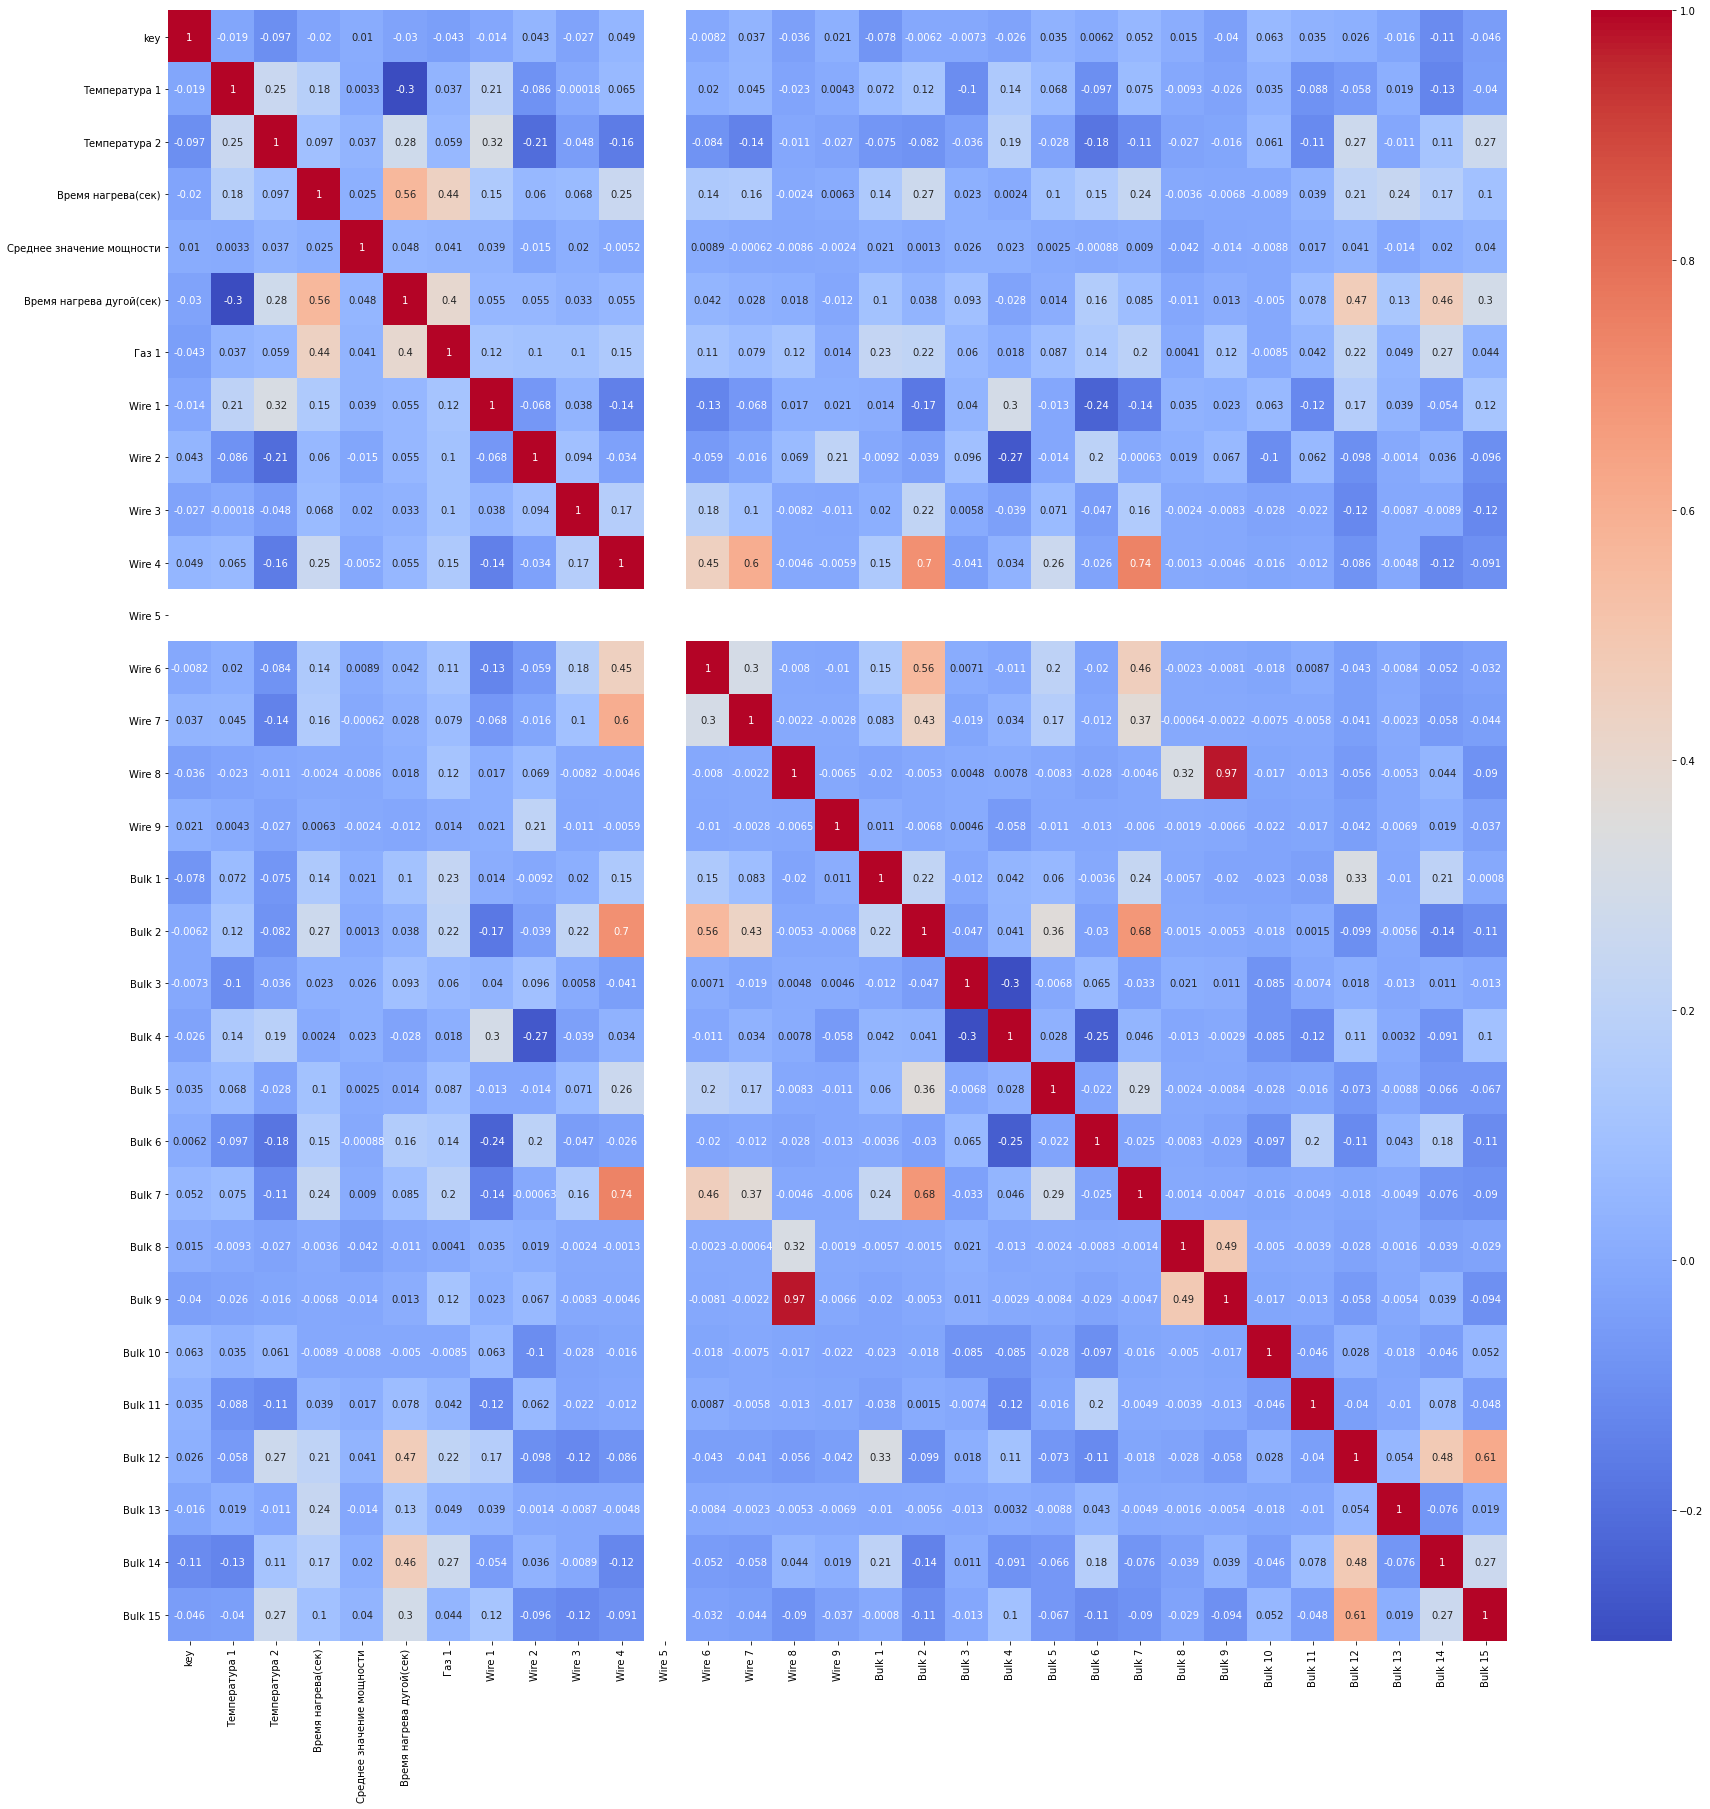

In [32]:
# Вычислим корреляционную матрицу
correlation_matrix = df.corr()
# Выведем графически корреляционную матрицу
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

по матрцие кореляций видим, что есть слабо коррелируемые и вообще пустые значения, их мы в дальнейшем удалим.

In [33]:
df.drop(['Wire 5','Время 1', 'Время 2'],inplace=True, axis=1)

заметим, что наш целевой признак - конечная температура (Температура 2) хорошо коррелирует с такими столбцами как:
- "Температура 1" (начальная температура) 
- "Время нагрева дугой(сек)"
- "Wire 1"
- "Bulk 4"
- "Bulk 12"
- "Bulk 14"
- "Bulk 15"

wire 8 и bulk 9 сильно коллерируют между собой, из-за этого возникает мультиколлинеарность. Что бы ее разрушить можно Удалить одну или несколько сильно коррелированных переменных. Удалим wire 8

In [34]:
df = df.drop(['Wire 8'], axis = 1)

Итого: Мы составили общую таблицу, в ней 2329 строк.
Посчетали дополнительные новые столбцы, сгруппировали и убрали все лишнее.
Построили корелляционную матрицу.

На следующем этапе мы начнем процесс обучения моделей.

## Обучение моделей

### Подготовка

In [35]:
train, test = train_test_split(df, test_size = 0.25, random_state = RANDOM_STATE)

cv_counts = 5

In [36]:
features_train = train.drop(['Температура 2','key'], axis =1)
target_train = train['Температура 2']

features_test = test.drop(['Температура 2','key'], axis =1)
target_test = test['Температура 2']

### LinearRegression

In [38]:
  
model = Pipeline([
    ('scaler', StandardScaler()),       # Масштабирование
    ('regression', LinearRegression())  # Линейная регрессия
])

MAE_LR = (cross_val_score(model, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE LinearRegression -', round(MAE_LR,3))



MAE LinearRegression - 6.701


### ForestRegressor

In [40]:
%%time
model = RandomForestRegressor() 

param_grid = [{'criterion':['mae'],
               'n_estimators': [50, 100, 150],
               'random_state':[RANDOM_STATE]}]

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=cv_counts)

grid_search.fit(features_train, target_train)

print('Лучшие параметры:', grid_search.best_params_)
print()

MAE_forest = max(grid_search.cv_results_['mean_test_score']) * -1
print('MAE Forest -', round(MAE_forest,3))

Лучшие параметры: {'criterion': 'mae', 'n_estimators': 150, 'random_state': 310723}

MAE Forest - 6.447
CPU times: user 3min 4s, sys: 189 ms, total: 3min 4s
Wall time: 3min 5s


### CatBoostRegressor

In [46]:
%%time

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [5, 7, 10],
    'n_estimators': [50, 100, 150]
}
cat_model = CatBoostRegressor(silent=True)
grid_search = GridSearchCV(cat_model, param_grid, cv=cv_counts, scoring='neg_mean_absolute_error')
grid_search.fit(features_train, target_train)
best_params = grid_search.best_params_
best_cat_model = grid_search.best_estimator_

print('Лучшие параметры:', grid_search.best_params_)
print()

MAE_CatBoost = max(grid_search.cv_results_['mean_test_score']) * -1
print('MAE CatBoost -', round(MAE_CatBoost,3))

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}

MAE CatBoost - 5.97
CPU times: user 3min 14s, sys: 1.9 s, total: 3min 16s
Wall time: 4min 53s


### Итог:
| ___ | LinearRegression | ForestRegressor | CatBoost |
| --- | --- | --- | --- |
| MAE | 6.701 | 6.447 | 5.97 |


Лучший результат показала модель CatBoostRegressor с параметрами 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150

## Тестирование модели

In [47]:
%%time          
          
cat_predict_test = best_cat_model.predict(features_test)
MAE_CatBoost_test = mean_absolute_error(target_test, cat_predict_test)
print("RMSE для CatBoostRegressor на тестовой:", round(MAE_CatBoost_test,3))

RMSE для CatBoostRegressor на тестовой: 5.823
CPU times: user 4.01 ms, sys: 47 µs, total: 4.05 ms
Wall time: 2.44 ms


In [40]:
# КОД ТИМЛИДА
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
model = CatBoostRegressor(verbose=0, **params)
model.fit(features_train, target_train)
cat_predict_test = model.predict(features_test)
MAE_CatBoost_test = mean_absolute_error(target_test, cat_predict_test)
print("RMSE для CatBoostRegressor на тестовой:", round(MAE_CatBoost_test,3))

RMSE для CatBoostRegressor на тестовой: 5.823


Качество на тестовой выборке критично не изменилось, это говрит нам о том, что выбранная модель не сломается на новых данных и мы можем смело рекомендовать ее.

### Проверка адекватности модели 

In [48]:
model = DummyRegressor(strategy='mean') # Создание базовой модели DummyRegressor
model.fit(features_train, target_train)
predict=model.predict(features_train)
MAE = mean_absolute_error(target_train, predict)
print('MAE DummyRegressor:', round(MAE,3))

MAE DummyRegressor: 8.279


Если MAE основной модели меньше, чем MAE базовой модели, это говорит о том, что модель является адекватной. 5.975 < 8.279

Модель адекватна
 

### Изучение значимсти признаков

In [49]:
#features_name = features_train.columns

In [50]:
importances = best_cat_model.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results

,feature,importance
0,Время нагрева дугой(сек),26.874178
1,Температура 1,26.045472
2,Время нагрева(сек),9.710127
3,Wire 1,6.097600
4,Bulk 15,5.161245
5,Bulk 6,5.108518
6,Wire 2,3.833573
7,Bulk 1,2.809561
8,Газ 1,2.677819
9,Bulk 14,2.634625


Признаки Wire 6, Bulk 3,Wire 7,Bulk 5,Wire 4,ulk 11,Bulk 10,Bulk 7,Wire 3,Bulk 2,Wire 9	,Bulk 8,Bulk 9 и Bulk 13 не значимы, т.е ценности ососбой не представляют.

Самым ценным признаком является Время нагрева дугой(сек) и начальная температура. Это было ожидаемо.

## Вывод

В ходе работы был проведен исследовательский анализ, где мы 
- заменили пропуски на ноль в таблицах с примесями сыпучих и проволочных материалов. 
- Удалили пропуски в таблице с температурой. 
- Посчитали среднее значение мощности
- Обработали начальное и конечное время и температура (удалены значения с одной отметкой времмени и удалены промежуточные значения)
Так же была создана таблица с общими данными, в которую вошли новые признаки-столбцы, созданные на основе значений времени в датасетах с энергией и температуррой (df_arc и df_temp)


Создав корреляционную матрицу, стало ясно, что наш целевой признак "Конечная температура" лучше всего коррелирует со следующими признаками : ("Температура 1" (начальная температура),
"Время нагрева дугой(сек)",
"Wire 1",
"Bulk 4",
"Bulk 12",
"Bulk 14",
"Bulk 15")

При этом мы исключили мультиколлинеарность


На следующем этапе было произведено разделение всех данных на тестовую и тренировочную выборки.

После обучения моделей мы получили следующие результаты:
- LinearRegression, МАЕ = 6.701	
- RandomForestRegressor с параметром 'n_estimators'= 150, МАЕ = 6.443	
- CatBoostRegressor с параметрами 'learning_rate'= 0.1, 'max_depth'= 5, 'n_estimators'= 150, МАЕ = 5.958

На тестовой выборке у модели CatBoostRegressor МАЕ = 5.712


Проверку на адекватность модель прошла.


Самым ценным признаком является Время нагрева дугой(сек) и начальная температура


Условия были соблюдены. МАЕ во всех трех моделях получились меньше 6.8


## Отчет

1. Работа прошла в соответствие с планом. На этапе выбора модели было приянто решение остановиться на трех моделях: LinearRegression,RandomForest, CatBoost. Так же в дополнение к плану была добавлена проверка на адекватность, которую модель прошла успешно. Время нагрева(сек) и время нагрева дуг(сек) получено с помощью разницы начального конечного времени на данных этапах. 


2. На протяжение работы трудности были с созданием и проверкой моделей, обучение, без правильно подобранных параметров проходит очень долго. 


3. После проделанной работы ключевыми можно назвать следующие шаги: 
- преобразуем данные
- рассчитываем время нагрева, мощность
- объединяем данные из разных источников
- удаляем ненужные данные
- разделяем данные на выборки
- масштабируем
- обучаем
- тестируем
- опркделяем значимость признаков
- делаем вывод
4. Для обучения моделей мы использовали целевой признак - Конечная температура. В качестве предобработки был проведен анализ и разбиение температуры на начальную и конечную. Нецелевые признаки, такие как средняя мощность (посчитана как среднее между активной и реактивной), 

5. Итоговая модель CatBoostRegressor имеет наименьший МАЕ среди остальных, гиперпараметры - {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
- МАЕ на основной = 5.958
- МАЕ на тестовой = 5.712
- МАЕ на базовой = 8.279


## Отчет

1. Работа прошла в соответствие с планом. На этапе выбора модели было приянто решение остановиться на трех моделях: LinearRegression,RandomForest, CatBoost. Так же в дополнение к плану была добавлена проверка на адекватность, которую модель прошла успешно. Время нагрева(сек) и время нагрева дуг(сек) получено с помощью разницы начального конечного времени на данных этапах. 


2. На протяжение работы трудности были с созданием и проверкой моделей, обучение, без правильно подобранных параметров проходит очень долго. 


3. После проделанной работы ключевыми можно назвать следующие шаги: 
- преобразуем данные
- рассчитываем время нагрева, мощность
- объединяем данные из разных источников
- удаляем ненужные данные
- разделяем данные на выборки
- масштабируем
- обучаем
- тестируем
- опркделяем значимость признаков
- делаем вывод
4. Для обучения моделей мы использовали целевой признак - Конечная температура. В качестве предобработки был проведен анализ и разбиение температуры на начальную и конечную. Нецелевые признаки, такие как средняя мощность (посчитана как среднее между активной и реактивной), 

5. Итоговая модель CatBoostRegressor имеет наименьший МАЕ среди остальных, гиперпараметры - {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
- МАЕ на основной = 5.958
- МАЕ на тестовой = 5.712
- МАЕ на базовой = 8.279
